## Collatz lambda notebook

In [239]:
"""
This notebook analyses the binary growth of a Collatz sequence, denoted by lambda.
"""

# Fix possible import problems
import sys
sys.path.append("..")

# Imports
from math import log2
import random as rnd
import matplotlib.pyplot as plt
import pandas as pd
from collatz import commons


# Helper methods
def _odd_collatz_components(odd_number:int, k=3):
    """
    This method returns the following components of an odd Collatz 
    number and a particular k factor:
    1.) vi: The odd number
    2.) kvi: The odd number multiplied with k
    3.) kvi+1: The value kvi + 1
    4.) vi_1: The next odd number
    :param odd_number: The odd number as int
    :param k: The k factor, default is three
    :return: The components as dict
    """
    vi = odd_number
    k_vi = k * odd_number
    k_vi_1 = k_vi + 1
    vi_1 = k_vi_1 / 2**commons.trailing_zeros(k_vi_1)
    result_dict = {
        "vi": vi,
        "kvi": k_vi,
        "kvi+1": k_vi_1,
        "vi_1": vi_1
    }
    return result_dict


def _odd_collatz_sequence_components(
        start_value:int, k=3, max_iterations=100):
    """
    This method returns the components of a specific Collatz sequence as generated by 
    the method _odd_collatz_components.
    :param start_value: The odd number to start with. The value must be a
    natural number > 0. If an even number is handed over, the next odd number will be used
    as start value.
    :param k: The factor that is multiplied with odd numbers (default is 3).
    :param max_iterations: The maximum number of iterations performed
    before the method exits. Default is -1, meaning that no max number of iterations is set.
    :return: A pandas data frame with the Collatz components.
    """
    result_frame = None
    odd_sequence = commons.odd_collatz_sequence(
        start_value, k, max_iterations)
    
    for i, odd in enumerate(odd_sequence):
        components = _odd_collatz_components(odd, k)
        del components["vi_1"]
        
        current_frame = pd.DataFrame({
            "n": i + 1,
            "variable": list(components.keys()),
            "decimal": list(components.values())
        })
        if result_frame is not None:
            result_frame = result_frame.append(current_frame)
        else:
            result_frame = current_frame
            
    result_frame["decimal"] = result_frame["decimal"].astype('int64')
    result_frame = result_frame.reset_index(drop=True)
    return result_frame


# Configuration
MAX_VALUE = 101
K_FACTOR = 3
MAX_ITERATIONS = 50
PRINT_TABLE = True

START_VALUE = rnd.randint(1, MAX_VALUE)

if START_VALUE % 2 == 0:
    START_VALUE = START_VALUE + 1

# START_VALUE = 85

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', 10000)
pd.set_option('display.expand_frame_repr', False)

# Create a collatz components
analysis_frame = _odd_collatz_sequence_components(
    START_VALUE, K_FACTOR, MAX_ITERATIONS)

# Derive new fields
analysis_frame["alpha_i"] = analysis_frame["decimal"].apply(commons.trailing_zeros)
analysis_frame["alpha_i"] = analysis_frame["alpha_i"].astype('int64')
analysis_frame["alpha"] = analysis_frame["alpha_i"].cumsum()

analysis_frame["log2"] = analysis_frame["decimal"].apply(log2)
analysis_frame["bin_str"] = analysis_frame["decimal"].apply(commons.to_binary)
analysis_frame["bin_len"] = analysis_frame["log2"].astype('int64') + 1
analysis_frame["lambda_hyp"] = (analysis_frame["n"] * log2(K_FACTOR))
analysis_frame["lambda_max"] = analysis_frame["lambda_hyp"].astype('int64') + 2

prev_bin_len = list(analysis_frame[:-1]["bin_len"])
prev_bin_len.insert(0, prev_bin_len[0])
analysis_frame["bin_diff"] = analysis_frame["bin_len"] - pd.Series(prev_bin_len)

analysis_frame["lambda_i"] = analysis_frame["bin_diff"]
analysis_frame.loc[analysis_frame["lambda_i"] < 0, "lambda_i"] = 0
analysis_frame["lambda"] = analysis_frame["lambda_i"].cumsum()

next_decimal = list(analysis_frame[1:]["decimal"])
next_decimal.append(0)
analysis_frame["next_decimal"] = next_decimal

# Remove components of the final result
analysis_frame = analysis_frame[:-3]

# Validate lambda
l_max_valid = int((analysis_frame["lambda"] > analysis_frame["lambda_max"]).sum()) < 1

# Print results
print_frame = analysis_frame[[
    "n", "variable", "decimal", "next_decimal",
    "log2", "bin_str", "bin_len",
    "lambda_i", "lambda", "lambda_max",
    "alpha"
]]

print_frame.columns = [
    "n","var", "dec", "next", 
    "log2", "b_str", "b_len",
    "l_i", "l", "l_max",
    "a"
]

print("Start value:", START_VALUE, 
      " K:", K_FACTOR, 
      "Lambda max valid:", l_max_valid,
      "\n")

if PRINT_TABLE:
    print(print_frame.to_string(), "\n")

Start value: 17  K: 3 Lambda max valid: True 

   n    var  dec  next      log2   b_str  b_len  l_i  l  l_max  a
0  1     vi   17    51  4.087463   10001      5    0  0      3  0
1  1    kvi   51    52  5.672425  110011      6    1  1      3  0
2  1  kvi+1   52    13  5.700440  110100      6    0  1      3  2
3  2     vi   13    39  3.700440    1101      4    0  1      5  2
4  2    kvi   39    40  5.285402  100111      6    2  3      5  2
5  2  kvi+1   40     5  5.321928  101000      6    0  3      5  5
6  3     vi    5    15  2.321928     101      3    0  3      6  5
7  3    kvi   15    16  3.906891    1111      4    1  4      6  5
8  3  kvi+1   16     1  4.000000   10000      5    1  5      6  9 



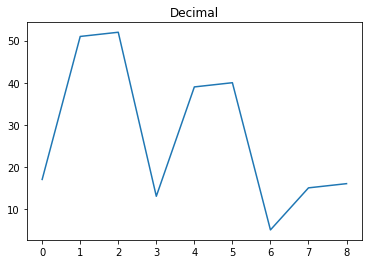

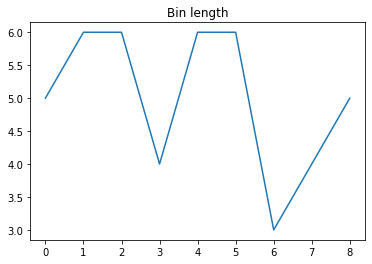

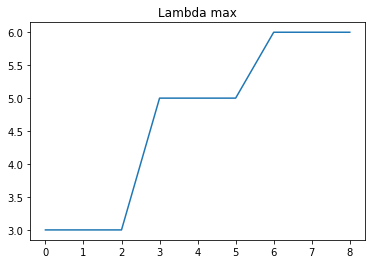

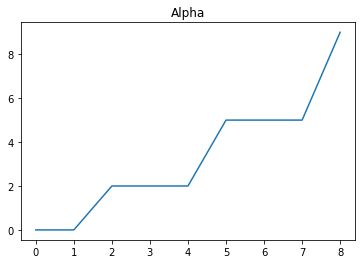

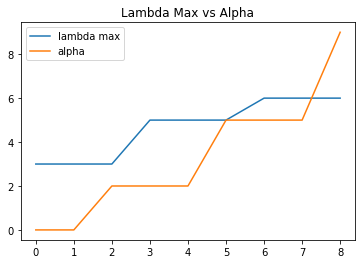

In [240]:
#Plot results
# Decimal
plt.figure()
plt.title("Decimal")
plt.plot(analysis_frame["decimal"], "-")

# Bin len
plt.figure()
plt.title("Bin length")
plt.plot(analysis_frame["bin_len"], "-")

plt.figure()
plt.title("Lambda max")
plt.plot(analysis_frame["lambda_max"], "-")

plt.figure()
plt.title("Alpha")
plt.plot(analysis_frame["alpha"], "-")

plt.figure()
plt.title("Lambda Max vs Alpha")
plt.plot(analysis_frame["lambda_max"], label="lambda max")
plt.plot(analysis_frame["alpha"], label="alpha")
plt.legend()

plt.show()